In [2]:
!pip install pot
!pip install torch
!pip install geomloss
!pip install wget


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from geomloss import SamplesLoss

import ot

import os
import pickle as pkl
import copy

from sklearn.preprocessing import scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from utils import *
from SoftImpute import softimpute, cv_softimpute
from DataSetLoader import dataset_loader, ground_truth
from SinkhornImputation import SinkhornImputation
from RR_imputer import RRimputer
from Sinkhorn_CMI import SinkhornImputation_CMI
import matplotlib.pyplot as plt

import argparse
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

torch.set_default_tensor_type('torch.DoubleTensor')

c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [4]:
from sklearn.datasets import load_wine

# Load the Wine dataset
wine = load_wine()

# Display feature names
print("Feature Names:")
print(wine.feature_names)


Feature Names:
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


In [5]:
#ground_truth_numpy = scale(load_wine()['data']) #only taking the features
Xy = {}
with open(r'C:\Users\zhossai3\Desktop\My code\OT+Fairness\Data\portugal student performance dataset\P_Student_Performance_Data.csv', 'rb') as f:
        df = pd.read_csv(f, delimiter=',', header = 0)
        Xy['data'] = df.values[:, :-1].astype('float')
        Xy['target'] =  df.values[:, -1]
ground_truth_numpy = scale(Xy['data'])
print(type(ground_truth_numpy))
print(type(ground_truth_numpy))
print(np.max(ground_truth_numpy))
print(np.min(ground_truth_numpy))
print(np.mean(ground_truth_numpy))
print(np.median(ground_truth_numpy))
print(np.std(ground_truth_numpy))
print(ground_truth_numpy.shape)
ground_truth = torch.from_numpy(ground_truth_numpy)
print(ground_truth.isnan().sum())

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
9.150126670101555
-4.7441041972812386
-3.773774598403673e-17
-0.22237479499833032
1.0
(382, 52)
tensor(0)


In [25]:
data_mar30_mask, missing_ind= MAR_mask(ground_truth_numpy, 0.6, 0.5)

In [26]:
data_mar30_mask

array([[ True,  True, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False]])

In [27]:
data_mar30 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mar30[data_mar30_mask] = np.nan

# Convert to a torch tensor
data_mar30 = torch.from_numpy(data_mar30)

# Calculate the percentage of missing values
missing_values_mar30 = torch.isnan(data_mar30)  
missing_percentage_mar30 = torch.sum(missing_values_mar30).item() / data_mar30.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mar30:.2f}%")

Percentage of missing values: 29.93%


In [28]:
data_mar30

tensor([[    nan,     nan,  1.2062,  ...,  0.0668, -4.7441, -0.5023],
        [    nan,     nan,  0.3529,  ..., -0.3414, -1.2191, -0.5023],
        [-0.3420, -0.9640, -1.3537,  ...,  0.4750, -0.0441,  0.3090],
        ...,
        [    nan,     nan,  1.2062,  ...,  0.4750, -0.4358, -0.0966],
        [ 2.9240,     nan,  0.3529,  ...,  0.4750, -0.8274, -0.9080],
        [    nan,     nan,  1.2062,  ...,  0.0668, -0.8274, -0.5023]])

In [29]:
torch.sum(missing_values_mar30).item()

5946

In [30]:
np.isnan(data_mar30).sum()

C:\Users\zhossai3\AppData\Local\Temp\ipykernel_24000\1030270582.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.isnan(data_mar30).sum()


tensor(5946)

In [31]:
mar30 = data_mar30.clone()

In [32]:
similarity = torch.equal(mar30, data_mar30)
print(similarity)

False


In [33]:
#sinkhorn
n_mar30, d_mar30 = mar30.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mar30 = pick_epsilon(mar30)
print(epsilon_mar30)

sk_imputer_mar30 = SinkhornImputation_CMI(eps=epsilon_mar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mar30, sk_maes30mar, sk_rmses30mar,sk_loss_mar30, initial_missing_mar30,imps_mar_30, imps_evaluation,grad_evaluation = sk_imputer_mar30.fit_transform(mar30, verbose=True, report_interval=50, X_true=ground_truth)
#using numpy version of data
sk_imp_mar30_numpy = sk_imp_mar30.detach().cpu().numpy()

sk_mae_mar30 = MAE(sk_imp_mar30_numpy,ground_truth_numpy ,data_mar30_mask)
sk_rmse_mar30 = RMSE(sk_imp_mar30_numpy, ground_truth_numpy,data_mar30_mask)
print(sk_mae_mar30,sk_rmse_mar30)

INFO:root:Iteration 0:	 Loss: 10.7695	 Validation MAE: 0.8007	RMSE: 1.0054


1.674646825194319


INFO:root:Iteration 50:	 Loss: 9.8101	 Validation MAE: 0.7092	RMSE: 0.9391
INFO:root:Iteration 100:	 Loss: 10.1642	 Validation MAE: 0.7020	RMSE: 0.9296
INFO:root:Iteration 150:	 Loss: 9.4975	 Validation MAE: 0.6988	RMSE: 0.9255
INFO:root:Iteration 200:	 Loss: 8.8008	 Validation MAE: 0.6996	RMSE: 0.9238
INFO:root:Iteration 250:	 Loss: 9.8605	 Validation MAE: 0.6996	RMSE: 0.9218
INFO:root:Iteration 300:	 Loss: 10.1014	 Validation MAE: 0.6984	RMSE: 0.9205
INFO:root:Iteration 350:	 Loss: 10.0295	 Validation MAE: 0.6999	RMSE: 0.9201
INFO:root:Iteration 400:	 Loss: 9.9469	 Validation MAE: 0.6987	RMSE: 0.9197
INFO:root:Iteration 450:	 Loss: 9.9924	 Validation MAE: 0.6983	RMSE: 0.9192
INFO:root:Iteration 500:	 Loss: 10.5853	 Validation MAE: 0.6984	RMSE: 0.9184
INFO:root:Iteration 550:	 Loss: 10.2095	 Validation MAE: 0.6989	RMSE: 0.9183
INFO:root:Iteration 600:	 Loss: 10.2183	 Validation MAE: 0.6991	RMSE: 0.9180
INFO:root:Iteration 650:	 Loss: 10.0942	 Validation MAE: 0.6979	RMSE: 0.9168
INFO:r

0.6984123493978088 0.9149680606375694


In [34]:
print(imps_mar_30)

tensor([ 0.2798, -0.1279, -0.2006,  ...,  0.3071,  0.3207, -0.1909],
       requires_grad=True)


initial_missing_mar30

In [35]:
initial_missing_mar30.size()

torch.Size([5946])

In [36]:
print(initial_missing_mar30)

tensor([-0.0093,  0.1692,  0.0439,  ...,  0.0559, -0.0613, -0.0558])


In [37]:
imps_mar_30.size()

torch.Size([5946])

In [38]:
print(imps_mar_30)

tensor([ 0.2798, -0.1279, -0.2006,  ...,  0.3071,  0.3207, -0.1909],
       requires_grad=True)


In [39]:
same_values_mask = (imps_mar_30 == initial_missing_mar30)

# Get the indices where the values are the same
same_indices = torch.nonzero(same_values_mask).squeeze()

# Print the indices and the values that are the same
print("Indices where values are the same:", same_indices)
print("Values that are the same:", imps_mar_30[same_indices])

Indices where values are the same: tensor([], dtype=torch.int64)
Values that are the same: tensor([], grad_fn=<IndexBackward0>)


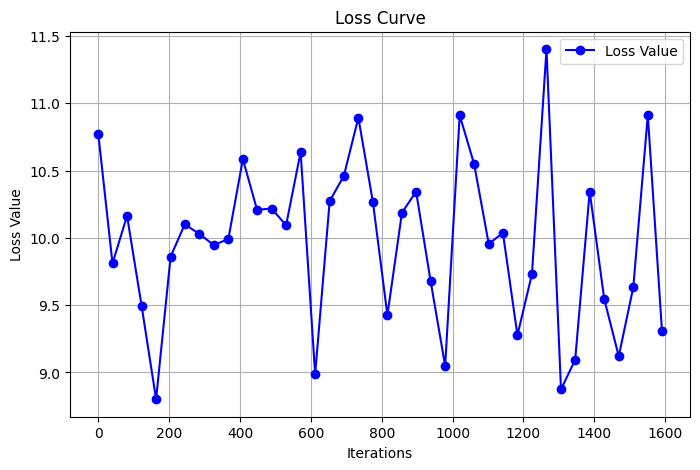

In [40]:
# Convert the list of losses to a NumPy array

iterations = np.linspace(0, 2000, 50).astype(int)



loss_values = sk_loss_mar30


# Assuming cmi_penalty_history is also a list, convert it to a NumPy array
#cmi_penalty_history_numpy = np.array(cmi_penalty_history)

# Total loss calculation
#total_loss = sk_loss_mcar30_numpy + cmi_penalty_history_numpy
if len(loss_values) > len(iterations):
    loss_values = loss_values[:len(iterations)]
elif len(loss_values) < len(iterations):
    iterations = iterations[:len(loss_values)]



# Plotting
plt.figure(figsize=(8, 5))
plt.plot(iterations, loss_values, color='b', linestyle='-', marker='o', label="Loss Value")
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

